In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [2]:
torch.__version__

'1.9.0+cu102'

---
## Data Confirm

In [16]:
# Check Current Directory
os.listdir('data/../')

['.config', 'data', '.ipynb_checkpoints', 'sample_data']

Each train Data and test data is in 'Zipfile'
So, We need to extract from ZipFile

In [11]:
# Make Directory for extracting from Zip
os.makedirs('data/', exist_ok=True)

In [17]:
# Train_dir, Test_dir
base_dir = 'data/../'
train_dir = 'data/train'
test_dir = 'data/test'

In [19]:
# Extract All Data From Zip to "../data" Directory
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('data/')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('data/')

In [20]:
# Check File Name
os.listdir(train_dir)[:5]

['dog.288.jpg',
 'cat.8765.jpg',
 'dog.12365.jpg',
 'cat.4596.jpg',
 'cat.9503.jpg']

In [21]:
# FilePath List
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

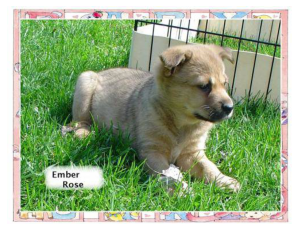

In [22]:
img = Image.open(train_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()

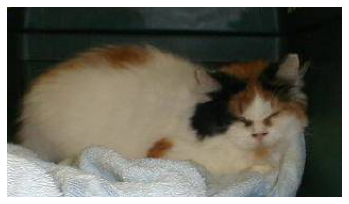

In [23]:
img = Image.open(test_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [24]:
# Label is contained in filepath
train_list[:5]

['data/train/dog.288.jpg',
 'data/train/cat.8765.jpg',
 'data/train/dog.12365.jpg',
 'data/train/cat.4596.jpg',
 'data/train/cat.9503.jpg']

In [25]:
# Image_Id is contained in filepath
test_list[:5]

['data/test/12020.jpg',
 'data/test/212.jpg',
 'data/test/4628.jpg',
 'data/test/6521.jpg',
 'data/test/932.jpg']

In [26]:
# Get Label
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [27]:
# Get Image_Id
int(test_list[0].split('/')[-1].split('.')[0])

12020

In [28]:
# Number of Train Image
len(train_list)

25000

In [29]:
# Nuber of Test Image
len(test_list)

12500

In [30]:
# Divide Train, Valid Data
train_list, val_list = train_test_split(train_list, test_size=0.1)

In [31]:
print(len(train_list))
print(len(val_list))

22500
2500


In [32]:
# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [33]:
# Dataset
class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [34]:
# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
# Dataset
train_dataset = DogvsCatDataset(train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_list, transform=ImageTransform(size, mean, std), phase='val')

# Operation Check
print('Operation Check')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

Operation Check
torch.Size([3, 224, 224])
0


In [36]:
# DataLoader
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

# Operation Check
print('Operation Check')
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

Operation Check
torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1])


---
## Model

In [37]:
# VGG16 Model Loading
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [38]:
# Change Last Layer
# Output Features 1000 → 2
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print('Done')

Done


In [39]:
# Specify The Layers for updating
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

---
## Train

In [41]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [46]:
# Train
num_epoch = 4
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/4
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.0399 Acc: 0.9848



val Loss: 0.0267 Acc: 0.9904
Epoch 2/4
--------------------



train Loss: 0.0400 Acc: 0.9850



val Loss: 0.0255 Acc: 0.9928
Epoch 3/4
--------------------



train Loss: 0.0417 Acc: 0.9838



val Loss: 0.0268 Acc: 0.9900
Epoch 4/4
--------------------



train Loss: 0.0408 Acc: 0.9844



val Loss: 0.0258 Acc: 0.9916
Training complete in 15m 13s
Best val Acc: 0.992800


---
## Predict

In [47]:
# Prediction
id_list = []
pred_list = []

with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        _id = int(test_path.split('/')[-1].split('.')[0])

        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        net.eval()

        outputs = net(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
    
    
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [48]:
res.head(10)

,id,label
0,1,9.994305e-01
1,2,9.999994e-01
2,3,9.998794e-01
3,4,9.998726e-01
4,5,3.110088e-08
5,6,1.733136e-04
6,7,1.994430e-07
7,8,1.631631e-05
8,9,2.683975e-07
9,10,1.901477e-05


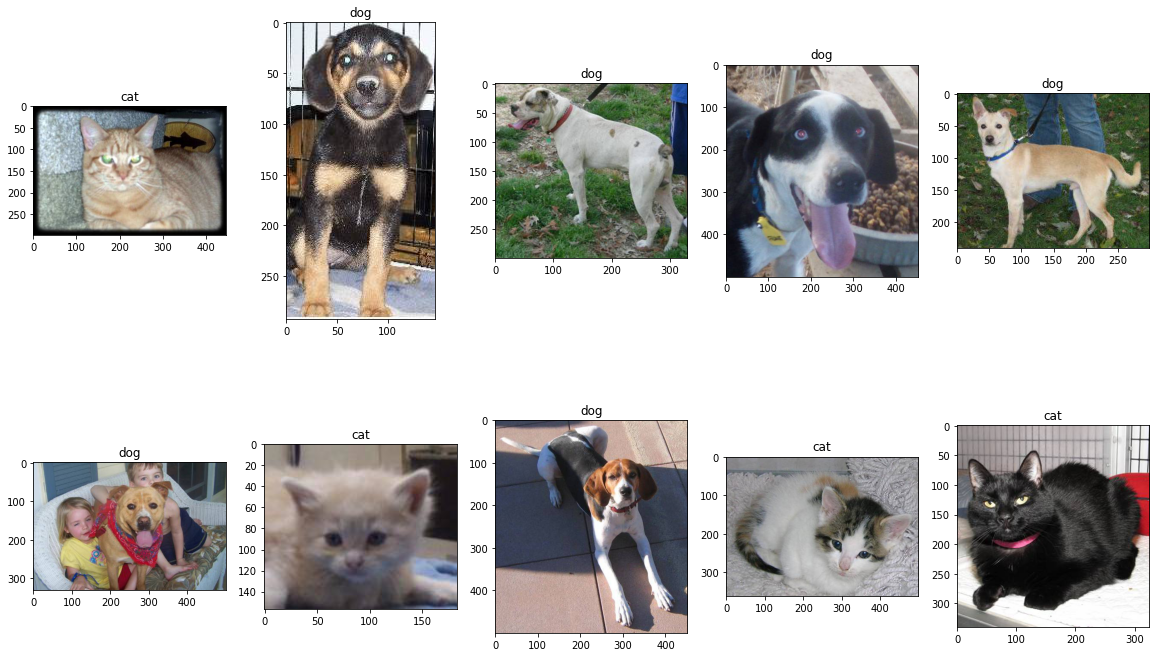

In [50]:
# Visualize Prediction
id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(res['id'].values)
    
    label = res.loc[res['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)